In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/16 15:21:54 WARN Utils: Your hostname, localhost, resolves to a loopback address: 127.0.0.1; using 10.255.255.254 instead (on interface lo)
25/08/16 15:21:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/16 15:21:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Read in data
yellow2018 = spark.read.parquet('./data/tlc_data/yellow2018/')
yellow2021 = spark.read.parquet('./data/tlc_data/yellow2021/')
yellow2024 = spark.read.parquet('./data/tlc_data/yellow2024/')
fhvhv2018 = spark.read.parquet('./data/tlc_data/fhvhv2018/')
fhvhv2021 = spark.read.parquet('./data/tlc_data/fhvhv2021/')
fhvhv2024 = spark.read.parquet('./data/tlc_data/fhvhv2024/')

In [5]:
yellow2018_count = yellow2018.count()
yellow2021_count = yellow2021.count()
yellow2024_count = yellow2024.count()
fhvhv2024_count = fhvhv2024.count()

In [6]:
# Form a data frame of yellow taxi trips
df = pd.DataFrame({
    "year": [2018, 2021, 2024],
    "count": [yellow2018_count, yellow2021_count, yellow2024_count]
})
print(df)

   year      count
0  2018  102871387
1  2021   30904308
2  2024   41169720


In [7]:
yellow2024.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 VendorID              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 RatecodeID            | 1                   
 store_and_fwd_flag    | N                   
 PULocationID          | 186                 
 DOLocationID          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 Airport_fee           | 0.0                 
only showing top 1 row


Data preprocessing

In [8]:
from pyspark.sql import functions as F

In [9]:
# Read in location information
zones = (
    spark.read.option("header", True).csv('./data/tlc_data/taxi_zone_lookup.csv')
    .select(
        # Select "LocationID", "Borough", and "Zone"
        F.col("LocationID").cast("int").alias("LocationID"),
        "Borough", "Zone")
)

# Create two new df for engaged and un engaged zones respectively,
# and rename the columns to match the locationIDs.
pu_zones = zones.select(
    F.col("LocationID").alias("PULocationID"),
    F.col("Borough").alias("PU_Borough"),
    F.col("Zone").alias("PU_Zone")
)

do_zones = zones.select(
    F.col("LocationID").alias("DOLocationID"),
    F.col("Borough").alias("DO_Borough"),
    F.col("Zone").alias("DO_Zone")
)

In [10]:
# Create a function to separate pick-up time into year, month, which day in a week, and hour
def time_separate(sdf, col):
    return (sdf.withColumn("year",  F.year(F.col(col)))
               .withColumn("month", F.month(F.col(col)))
               .withColumn("day", F.dayofweek(F.col(col)))
               .withColumn("hour",  F.hour(F.col(col)))
    )

In [11]:
# Clean yellow$$$$ data
def yellow(sdf):
    # Change and unify data types
    sdf = (sdf
        .withColumn("trip_distance",   F.col("trip_distance").cast("double"))
        .withColumn("tip_amount",   F.col("tip_amount").cast("double"))
        .withColumn("total_amount",   F.col("total_amount").cast("double"))
        .withColumn("fare_amount",  F.col("fare_amount").cast("double"))
        .withColumn("tpep_pickup_datetime",  F.to_timestamp("tpep_pickup_datetime"))
        .withColumn("tpep_dropoff_datetime", F.to_timestamp("tpep_dropoff_datetime"))
    )
    # Filter out abnormal and null data
    sdf = (sdf
        .filter(F.col("PULocationID").isNotNull() & F.col("DOLocationID").isNotNull())
        .filter(F.col("trip_distance")   > 0)
        .filter(F.col("fare_amount")  > 0)
        .filter(F.col("total_amount")   > 0)
        .filter(F.col("trip_distance")   <= 200)
    )
    # Combine two location dfs with sdf
    sdf = (sdf
          .join(pu_zones, on="PULocationID", how="left")
          .join(do_zones, on="DOLocationID", how="left")
    )
    # Create a column record the trips to and from airports
    sdf = sdf.withColumn(
        "airport",
        (F.lower(F.col("PU_Zone")).contains("airport") | F.lower(F.col("DO_Zone")).contains("airport")).cast("boolean")
    )
    # Separate the pick-up datetime
    sdf = time_separate(sdf, "tpep_pickup_datetime")
    # Choose columns that should be kept
    cols = [
        "tpep_pickup_datetime","tpep_dropoff_datetime",
        "PULocationID","DOLocationID","PU_Borough","DO_Borough","PU_Zone","DO_Zone",
        "trip_distance","total_amount","tip_amount","airport",
        "hour","day","month"
    ]
    return sdf.select(*cols)

In [12]:
fhvhv2024.show(1, vertical=True, truncate=100)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2024-01-01 00:21:47 
 on_scene_datetime    | 2024-01-01 00:25:06 
 pickup_datetime      | 2024-01-01 00:28:08 
 dropoff_datetime     | 2024-01-01 01:05:39 
 PULocationID         | 161                 
 DOLocationID         | 158                 
 trip_miles           | 2.83                
 trip_time            | 2251                
 base_passenger_fare  | 45.61               
 tolls                | 0.0                 
 bcf                  | 1.25                
 sales_tax            | 4.05                
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 0.0                 
 driver_pay           | 40.18               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

In [13]:
# Clean FHVHV data

def fhvhv(sdf):
    # Change and unify data types
    sdf = (sdf
        .withColumn("pickup_datetime",  F.to_timestamp("pickup_datetime"))
        .withColumn("dropoff_datetime", F.to_timestamp("dropoff_datetime"))
        .withColumn("trip_miles",     F.col("trip_miles").cast("double"))
        .withColumn("trip_time",      F.col("trip_time").cast("double"))
        .withColumn("tips",           F.coalesce(F.col("tips").cast("double"), F.lit(0.0)))
        .withColumn("driver_pay",     F.col("driver_pay").cast("double"))
    )
    # Filter out abnormal and null data
    sdf = (sdf
        .filter(F.col("PULocationID").isNotNull() & F.col("DOLocationID").isNotNull())
        .filter(F.col("trip_miles")   > 0)
        .filter(F.col("trip_time") > 0)
        .filter(F.col("driver_pay")   > 0)
        .filter(F.col("trip_miles")   <= 200)
    )
    # Combine two location dfs with sdf
    sdf = (sdf
        .join(pu_zones, on="PULocationID", how="left")
        .join(do_zones, on="DOLocationID", how="left")
    )
    # Create a column record the trips to and from airports
    sdf = sdf.withColumn(
        "airport",
        (F.lower(F.col("PU_Zone")).contains("airport") | F.lower(F.col("DO_Zone")).contains("airport")).cast("boolean")
    )
    # Separate the pick-up datetime
    sdf = time_separate(sdf, "pickup_datetime")
    # Choose columns that should be kept
    cols = [
        "pickup_datetime","dropoff_datetime",
        "PULocationID","DOLocationID","PU_Borough","DO_Borough","PU_Zone","DO_Zone",
        "trip_miles","trip_time","driver_pay","tips","airport",
        "hour","day","month"
    ]
    return sdf.select(*cols)

In [14]:
yellow18 = yellow(yellow2018)
yellow21 = yellow(yellow2021)
yellow24 = yellow(yellow2024)
fhvhv24 = fhvhv(fhvhv2024)

In [15]:
fhvhv24.show(5)

+-------------------+-------------------+------------+------------+----------+----------+---------------+--------------------+----------+---------+----------+----+-------+----+---+-----+
|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|PU_Borough|DO_Borough|        PU_Zone|             DO_Zone|trip_miles|trip_time|driver_pay|tips|airport|hour|day|month|
+-------------------+-------------------+------------+------------+----------+----------+---------------+--------------------+----------+---------+----------+----+-------+----+---+-----+
|2024-01-01 00:28:08|2024-01-01 01:05:39|         161|         158| Manhattan| Manhattan| Midtown Center|Meatpacking/West ...|      2.83|   2251.0|     40.18| 0.0|  false|   0|  2|    1|
|2024-01-01 00:12:53|2024-01-01 00:20:05|         137|          79| Manhattan| Manhattan|       Kips Bay|        East Village|      1.57|    432.0|      6.12| 0.0|  false|   0|  2|    1|
|2024-01-01 00:23:05|2024-01-01 00:35:16|          79|         18

In [16]:
# Count the trips of each year and each type of taxi
yellow18_count = yellow18.count()
yellow21_count = yellow21.count()
yellow24_count = yellow24.count()
fhvhv24_count = fhvhv24.count()

In [17]:
print(fhvhv24_count)

239371720


In [18]:
# Form a data frame of yellow taxi trips (cleaned)
count = pd.DataFrame({
    "year": [2018, 2021, 2024],
    "count": [yellow18_count, yellow21_count, yellow24_count]
})
print(count)

   year      count
0  2018  102098294
1  2021   30366905
2  2024   39705504


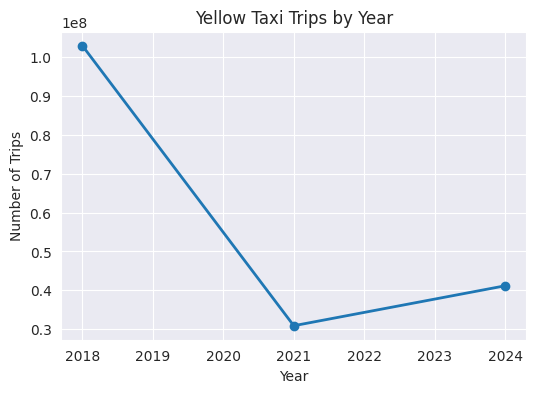

In [19]:
# Plot a line chart showing the changes of yellow taxi trips by year
plt.figure(figsize=(6,4))
plt.plot(df["year"], df["count"], marker="o", linewidth=2)
plt.title("Yellow Taxi Trips by Year")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()

In [20]:
# Calculate the average total_amount for each year
yellow18.agg(F.avg("total_amount")).show()
yellow21.agg(F.avg("total_amount")).show()
yellow24.agg(F.avg("total_amount")).show()
fhvhv24.agg(F.avg("driver_pay")).show()

+------------------+
| avg(total_amount)|
+------------------+
|16.352939964475095|
+------------------+



+------------------+
| avg(total_amount)|
+------------------+
|19.752691292168095|
+------------------+



+------------------+
| avg(total_amount)|
+------------------+
|28.650788401993044|
+------------------+



+------------------+
|   avg(driver_pay)|
+------------------+
|20.205578355216726|
+------------------+



In [21]:
# Airport trips / total trips
def calc_airport_ratio(df, year):
    # Count the total number of trips
    sdf = df
    total_trips = sdf.count()
    # Count airport trips
    airport_trips = sdf.filter(F.col("airport") == True).count()
    # Return (airport trips / total number of trips)
    return (year, airport_trips / total_trips)

# Calculate the percentage of airport trips for 2018, 2021, and 2024
airport_stats = []
for year, sdf in [(2018, yellow18), (2021, yellow21), (2024, yellow24)]:
    airport_stats.append(calc_airport_ratio(sdf, year))

# Transform to spark data frame
airport_df = spark.createDataFrame(airport_stats, ["year", "airport_ratio"])

airport_df.show()

+----+-------------------+
|year|      airport_ratio|
+----+-------------------+
|2018|0.07219259706729282|
|2021|0.07010115123684814|
|2024|0.10113882448136158|
+----+-------------------+



In [22]:
# Calculate the average tip_amount for each year
yellow18.agg(F.avg("tip_amount")).show()
yellow21.agg(F.avg("tip_amount")).show()
yellow24.agg(F.avg("tip_amount")).show()
fhvhv24.agg(F.avg("tips")).show()

[107.897s][warning][gc,alloc] Executor task launch worker for task 6.0 in stage 169.0 (TID 568): Retried waiting for GCLocker too often allocating 48783 words


+------------------+
|   avg(tip_amount)|
+------------------+
|1.8677323489890465|
+------------------+



+------------------+
|   avg(tip_amount)|
+------------------+
|2.3539042302797406|
+------------------+



+------------------+
|   avg(tip_amount)|
+------------------+
|3.3836964759362798|
+------------------+



+------------------+
|         avg(tips)|
+------------------+
|1.1742338529385083|
+------------------+



In [23]:
# Calculate the percentage of tips in total_amount
yellow18.agg(F.avg(F.col("tip_amount") / F.col("total_amount"))).show()
yellow21.agg(F.avg(F.col("tip_amount") / F.col("total_amount"))).show()
yellow24.agg(F.avg(F.col("tip_amount") / F.col("total_amount"))).show()
fhvhv24.agg(F.avg(F.col("tips") / F.col("driver_pay"))).show()

+--------------------------------+
|avg((tip_amount / total_amount))|
+--------------------------------+
|             0.10673460168446852|
+--------------------------------+



+--------------------------------+
|avg((tip_amount / total_amount))|
+--------------------------------+
|             0.11656762174326231|
+--------------------------------+



+--------------------------------+
|avg((tip_amount / total_amount))|
+--------------------------------+
|             0.11318581713754312|
+--------------------------------+



+------------------------+
|avg((tips / driver_pay))|
+------------------------+
|    0.056390582372111364|
+------------------------+



In [24]:
# Compare the number of trips in 2024 of fhvhv and yellow taxi
total = yellow24_count + fhvhv24_count

yellow24_perg = yellow24_count / total * 100
fhvhv24_perg  = fhvhv24_count  / total * 100

print(f"Yellow Taxi: {yellow24_perg:.1f}%")
print(f"FHVHV: {fhvhv24_perg:.1f}%")

Yellow Taxi: 14.2%
FHVHV: 85.8%


In [25]:
# Calculate the total trip, average distance, and average fare of yellow taxi group by month, day in a week, and hour
def group_by_time(sdf, time_col):

    result = (sdf.groupBy(time_col)
                 .agg(F.count("*").alias("trip_count"),
                      F.avg("trip_distance").alias("avg_distance"),
                      F.avg("total_amount").alias("avg_fare"))
                 .orderBy(time_col))

    return result

In [29]:
monthly_yellow18 = group_by_time(yellow18, "month")
hourly_yellow18  = group_by_time(yellow18, "hour")
weekday_yellow18 = group_by_time(yellow18, "day")

monthly_yellow18.show()
hourly_yellow18.show()
weekday_yellow18.show()

25/08/16 15:34:37 ERROR Executor: Exception in task 6.0 in stage 361.0 (TID 1212)
scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache

Py4JJavaError: An error occurred while calling o1978.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 361.0 failed 1 times, most recent failure: Lost task 3.0 in stage 361.0 (TID 1209) (10.255.255.254 executor driver): scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
Caused by: scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)


25/08/16 15:34:38 WARN TaskSetManager: Lost task 8.0 in stage 361.0 (TID 1214) (10.255.255.254 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 3 in stage 361.0 failed 1 times, most recent failure: Lost task 3.0 in stage 361.0 (TID 1209) (10.255.255.254 executor driver): scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	a

[765.179s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 361.0 (TID 1210): Retried waiting for GCLocker too often allocating 58700 words
[765.179s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 361.0 (TID 1208): Retried waiting for GCLocker too often allocating 65536 words
[765.183s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 361.0 (TID 1207): Retried waiting for GCLocker too often allocating 21956 words
[765.189s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 361.0 (TID 1210): Retried waiting for GCLocker too often allocating 7 words
[765.189s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 361.0 (TID 1208): Retried waiting for GCLocker too often allocating 12 words
[765.192s][warning][gc,alloc] Executor task launch worker for task 9.0 in stage 361.0 (TID 1215): Retried waiting for GCLocker too often allocating 29555 words
[765.195s][warning][gc,alloc] Executor task lau